## Binary classification problem. Sentiment needs to be predicted as accurately as possible.
#### Other than Polarity, all other columns may be used as predictors as needed.
Use Dataset: https://www.kaggle.com/aska88/end-of-usafghan-war-tweet-data

## Importing Required Libraries & Dataset

In [1]:
# Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re    # For regular expressions 
import nltk  # For text manipulation

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
# Importing Dataset
war_tweets = pd.read_csv('C:\\Users\\chaud\\Downloads\\Compressed\\US-Afghan_war_tweets.csv')
war_tweets

user_location             date  \
0                                        NaN  8/19/2021 23:59   
1                             washington, dc  8/19/2021 23:59   
2                                        NaN  8/19/2021 23:59   
3       midnapore, west bengal, uk outreach   8/19/2021 23:59   
4                              york, england  8/19/2021 23:59   
...                                      ...              ...   
362561                                 india  8/16/2021 12:10   
362562                                   NaN  8/16/2021 12:09   
362563                                 earth  8/16/2021 12:09   
362564                         mumbai, india  8/16/2021 12:09   
362565                   islamabad, pakistan  8/16/2021 12:08   

                                                     text sentiment  polarity  \
0         cant recall told troops afghanistan falsely ...  negative -0.300000   
1       shocker afghanistan taliban carrying doorto do...   neutral  0.000000   
2          drop bass bombs big homie afghanistan talibans  negative -0.075000   
3       burqa prices risen markets afghanistans provin...  negative -0.250000   
4       uk carved afghanistan s heroin minorities mili...   neutral  0.000000   
...                                                   ...       ...       ...   
362561  war taliban started afghans kabulhasfallen afg...   neutral  0.000000   
362562  words taliban rules women kabulhasfallen https...   neutral  0.000000   
362563  kabulhasfallen afghanistanburning country suff...  negative -0.071429   
362564  kabulhasfallen talibans terrorists deobandi ht...   neutral  0.000000   
362565  the afghans enemies fight fight war oth httpst...   neutral  0.000000   

                                                 hashtags               source  
0                                         ['afghanistan']   twitter for iphone  
1                                         ['afghanistan']     twitter for ipad  
2                             ['afghanistan', 'talibans']   twitter for iphone  
3                                         ['afghanistan']      twitter web app  
4                                         ['afghanistan']     twitter for ipad  
...                                                   ...                  ...  
362561            ['kabulhasfallen', 'afghanistancrisis']      twitter web app  
362562                                 ['kabulhasfallen']  twitter for android  
362563           ['kabulhasfallen', 'afghanistanburning']   twitter for iphone  
362564  ['kabulhasfallen', 'talibans', 'terrorists', '...  twitter for android  
362565                                                NaN  twitter for android  

[362566 rows x 7 columns]

## Exploratory Data Analysis

In [3]:
# Getting insight of the data
war_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362566 entries, 0 to 362565
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_location  261572 non-null  object 
 1   date           362565 non-null  object 
 2   text           362565 non-null  object 
 3   sentiment      362566 non-null  object 
 4   polarity       362566 non-null  float64
 5   hashtags       276205 non-null  object 
 6   source         362562 non-null  object 
dtypes: float64(1), object(6)
memory usage: 19.4+ MB


In [4]:
# Cheking for the Null Values
war_tweets.isnull().sum()

user_location    100994
date                  1
text                  1
sentiment             0
polarity              0
hashtags          86361
source                4
dtype: int64

#### Finding unique values in each features

In [5]:
# Creating new DataFrame of unique values in each features
war_tweets_unique = pd.DataFrame()
war_tweets_unique['Features'] = war_tweets.columns
unique = []
for i in war_tweets.columns:
    unique.append(war_tweets[i].nunique())
war_tweets_unique['Uniques'] = unique
war_tweets_unique

Features  Uniques
0  user_location    35072
1           date    12354
2           text   359903
3      sentiment        3
4       polarity     2567
5       hashtags    74712
6         source      415

Text(0, 0.5, 'Unique Values')

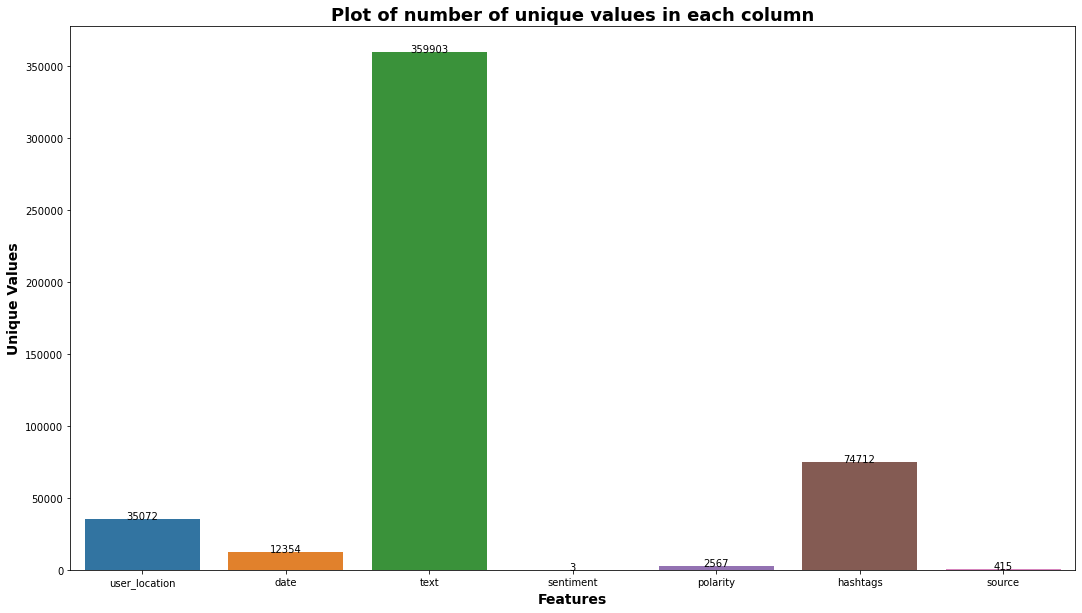

In [6]:
# Plotting unique values using Barplot
fig, ax = plt.subplots(figsize = (18,10))
splot = sns.barplot(x = 'Features', y = 'Uniques', data = war_tweets_unique)

# Annotating the Bars
for index, row in war_tweets_unique.iterrows():
    splot.text(row.name,row.Uniques, round(row.Uniques,2), color = 'black', ha = "center")

# Adding plot title
plt.title('Plot of number of unique values in each column',weight='bold', size=18)

# Adding X and Y label
plt.xlabel('Features', size=14, weight='bold')
plt.ylabel('Unique Values', size=14, weight='bold')

#### The dataset is having total 362565 tweets, however we can see that, there're only 359903 unique tweets.
#### Thus, we're required to remove the duplicate datapoints.

In [7]:
# Finding number of duplicate values in the tweets column of data
war_tweets['text'].duplicated().sum()

2662

In [8]:
# Removing the duplicates from the tweets column of data
war_tweets = war_tweets.drop_duplicates(subset = ['text'])

In [9]:
# Removing the NAN values from the tweets column of data & checking sum of null values
war_tweets = war_tweets.dropna(subset = ['text'])
war_tweets.isnull().sum()

user_location    99397
date                 0
text                 0
sentiment            0
polarity             0
hashtags         86357
source               3
dtype: int64

### Analysing tweets by location

In [10]:
# Top 20 tweets by location
war_tweets['user_location'].value_counts().head(20)

india                      11292
pakistan                    5824
new delhi, india            4333
islamabad, pakistan         4161
united states               4020
washington, dc              3466
london, england             2972
lahore, pakistan            2524
afghanistan                 2332
karachi, pakistan           2317
london                      2303
worldwide                   2300
usa                         2055
mumbai, india               1908
ethiopia                    1760
new delhi                   1623
united kingdom              1575
earth                       1420
uk                          1108
england, united kingdom     1021
Name: user_location, dtype: int64

In [11]:
# Plot of top location-wise 20 tweets 

import plotly.graph_objects as go

location_analysis = pd.DataFrame(war_tweets['user_location'].value_counts().sort_values(ascending=False))
location_analysis = location_analysis.rename(columns = {'user_location':'Counts'})

data = {
   "values": location_analysis['Counts'][:10],
   "labels": location_analysis.index[:10],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
        }
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

#### By looking visualizing the plot, we can conclude that, most of the tweets are from countries:
#### India & Pakistan

### Analysing the Sentiments

In [12]:
# Claculating the number of tweets for each sentiment
war_tweets['sentiment'].value_counts()

neutral     166329
negative    117349
positive     76225
Name: sentiment, dtype: int64

<AxesSubplot:>

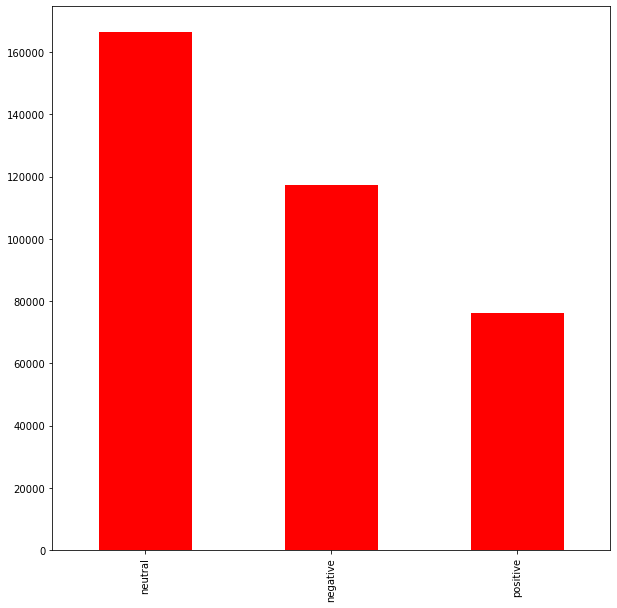

In [13]:
# Plotting the sentiments and values
(war_tweets['sentiment'].value_counts()).plot.bar(color = 'red', figsize = (10, 10))

#### From the plot we can conclude that, tweets with neutral sentiments are highest in number followed by negative and positive

In [14]:
# Extracting the data with neutral sentiments from the data
neutral_df = war_tweets[war_tweets['sentiment'] == 'neutral']
neutral_df.head()

user_location             date  \
1                                      washington, dc  8/19/2021 23:59   
4                                       york, england  8/19/2021 23:59   
10                                 powder springs, ga  8/19/2021 23:59   
14  ohio/cali            ã°âââã°âââã°âââã...  8/19/2021 23:58   
17                                                NaN  8/19/2021 23:58   

                                                 text sentiment  polarity  \
1   shocker afghanistan taliban carrying doorto do...   neutral       0.0   
4   uk carved afghanistan s heroin minorities mili...   neutral       0.0   
10  kabul afghanistan internal state department ca...   neutral       0.0   
14  afghanistan goodnews thursdaythoughts techies ...   neutral       0.0   
17    god women amp children  leave let taliban sa...   neutral       0.0   

                                             hashtags              source  
1                                     ['afghanistan']    twitter for ipad  
4                                     ['afghanistan']    twitter for ipad  
10                           ['kabul', 'afghanistan']  twitter for iphone  
14  ['afghanistan', 'goodnews', 'thursdaythoughts'...  twitter for iphone  
17                                        ['taliban']  twitter for iphone

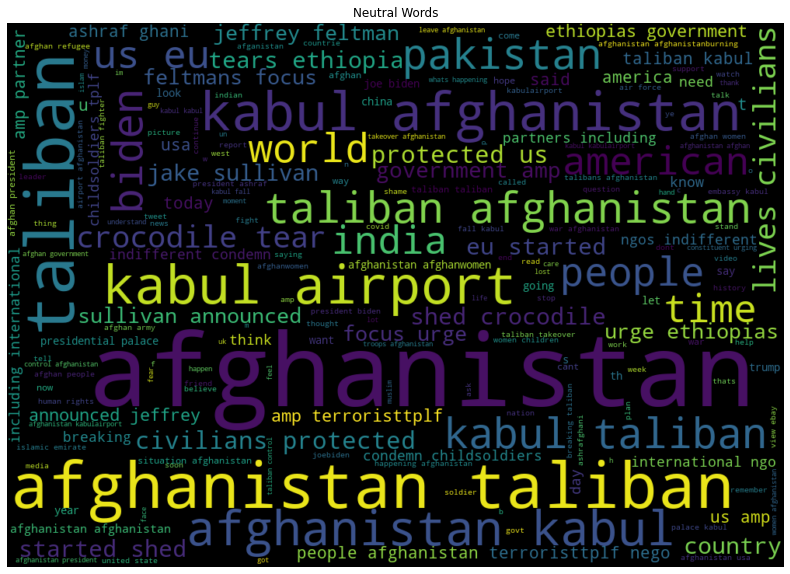

In [15]:
# Creating WordCloud for neutral sentiment

from wordcloud import WordCloud

neutral_words =' '.join([text for text in war_tweets['text'][war_tweets['sentiment'] == 'neutral']])

wordcloud = WordCloud(width=1000, height=700, random_state = 0, max_font_size = 130).generate(neutral_words)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Words')
plt.show()

In [16]:
# Extracting the data with negative sentiments from the data
negative_df = war_tweets[war_tweets['sentiment'] == 'negative']
negative_df.head()

user_location             date  \
0                                   NaN  8/19/2021 23:59   
2                                   NaN  8/19/2021 23:59   
3  midnapore, west bengal, uk outreach   8/19/2021 23:59   
6                        washington, dc  8/19/2021 23:59   
9                                  ohio  8/19/2021 23:59   

                                                text sentiment  polarity  \
0    cant recall told troops afghanistan falsely ...  negative    -0.300   
2     drop bass bombs big homie afghanistan talibans  negative    -0.075   
3  burqa prices risen markets afghanistans provin...  negative    -0.250   
6    pakistan closed borders refugees afghanistan...  negative    -0.100   
9    thing think current   administration terribl...  negative    -0.500   

                                  hashtags              source  
0                          ['afghanistan']  twitter for iphone  
2              ['afghanistan', 'talibans']  twitter for iphone  
3                          ['afghanistan']     twitter web app  
6  ['pakistan', 'refugees', 'afghanistan']     twitter web app  
9                                      NaN     twitter web app

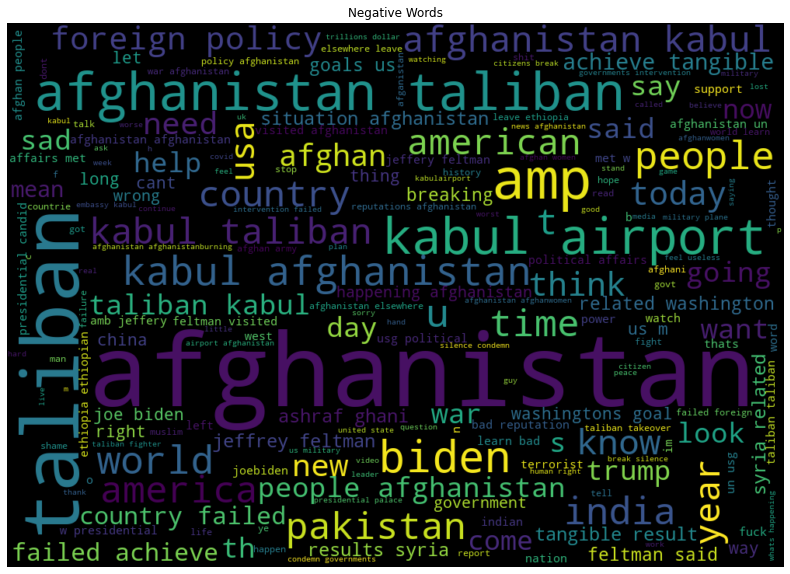

In [17]:
# Creating WordCloud for negative sentiment

from wordcloud import WordCloud

negative_words =' '.join([text for text in war_tweets['text'][war_tweets['sentiment'] == 'negative']])

wordcloud = WordCloud(width=1000, height=700, random_state = 0, max_font_size = 130).generate(negative_words)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [18]:
# Extracting the data with positive sentiments from the data
positive_df = war_tweets[war_tweets['sentiment'] == 'positive']
positive_df.head()

user_location             date  \
5           new delhi  8/19/2021 23:59   
7   dallas/fort worth  8/19/2021 23:59   
8               world  8/19/2021 23:59   
12             canada  8/19/2021 23:59   
13             london  8/19/2021 23:58   

                                                 text sentiment  polarity  \
5   afghanistan times changed pictures afghan wome...  positive  0.500000   
7   rather drawn political blame game believe far ...  positive  0.025000   
8          admit usarmy right invade httpstcojppyqqgm  positive  0.285714   
12     afghans care ready months   liar  afghanist...  positive  0.200000   
13      israel warned depend more vultures circle ...  positive  0.500000   

                      hashtags               source  
5              ['afghanistan']   twitter for iphone  
7                          NaN   twitter for iphone  
8                   ['usarmy']  twitter for android  
12  ['afghanistan', 'cdnpoli']   twitter for iphone  
13                  ['israel']  twitter for android

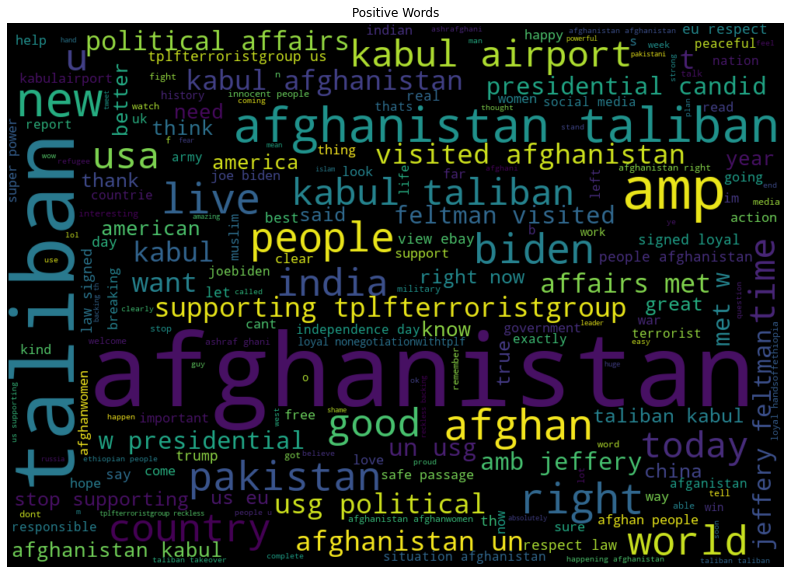

In [19]:
# Creating WordCloud for negative sentiment

from wordcloud import WordCloud

positive_words =' '.join([text for text in war_tweets['text'][war_tweets['sentiment'] == 'positive']])

wordcloud = WordCloud(width=1000, height=700, random_state = 0, max_font_size = 130).generate(positive_words)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Words')
plt.show()

#### Finding most occurred words

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

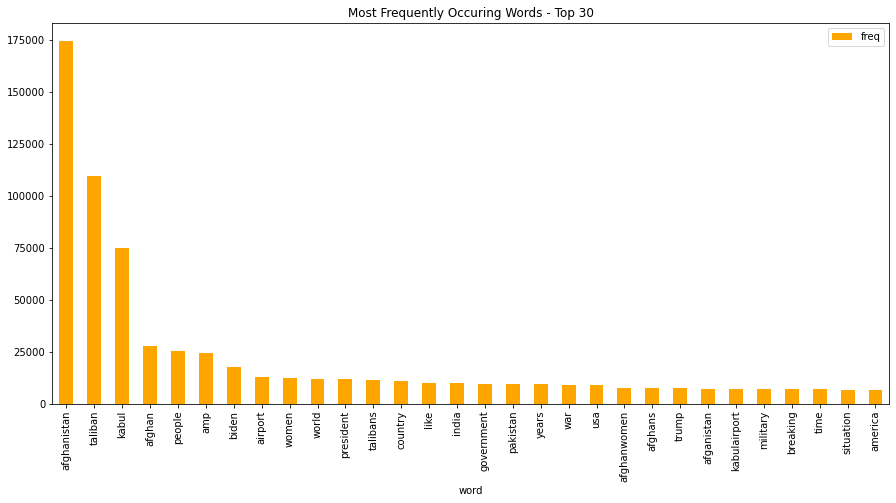

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(war_tweets.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Plot for top-30 most frequently occurred words
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'orange')
plt.title("Most Frequently Occuring Words - Top 30")

#### Hence, we can conclude that, the words 'afghanistan', 'taliban' and 'kabul' are the most repeated words in the tweets

### Analysing the distribution of tweets

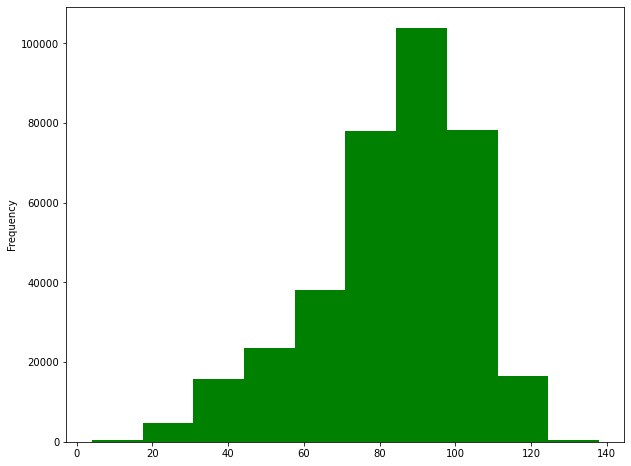

In [21]:
# Plotting the distribution of tweets using histplot

length_txt = war_tweets['text'].str.len().plot.hist(color = 'green', figsize = (10, 8))

#### By visualizing the plot, we can conclude that, the distribution is 'left skewed' and maximum number of tweets have word length ranging from 70 to 110 texts.

## Text Preprocessing

#### Features such as Location, Date, Hashtags, Source will not impact on the Sentiments and thus these can be eliminated from the analysis. Hence we'll consider 'Text' column for the further processing and analysis.

In [22]:
import re
import nltk
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords') # Downloading stopwords for removing them
from nltk.corpus import stopwords

In [23]:
# We'll write a function to make text lowercase and remove stopwords

stop_words = stopwords.words('english')
war_tweets['Tweets'] = war_tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
war_tweets

user_location             date  \
0                                        NaN  8/19/2021 23:59   
1                             washington, dc  8/19/2021 23:59   
2                                        NaN  8/19/2021 23:59   
3       midnapore, west bengal, uk outreach   8/19/2021 23:59   
4                              york, england  8/19/2021 23:59   
...                                      ...              ...   
362561                                 india  8/16/2021 12:10   
362562                                   NaN  8/16/2021 12:09   
362563                                 earth  8/16/2021 12:09   
362564                         mumbai, india  8/16/2021 12:09   
362565                   islamabad, pakistan  8/16/2021 12:08   

                                                     text sentiment  polarity  \
0         cant recall told troops afghanistan falsely ...  negative -0.300000   
1       shocker afghanistan taliban carrying doorto do...   neutral  0.000000   
2          drop bass bombs big homie afghanistan talibans  negative -0.075000   
3       burqa prices risen markets afghanistans provin...  negative -0.250000   
4       uk carved afghanistan s heroin minorities mili...   neutral  0.000000   
...                                                   ...       ...       ...   
362561  war taliban started afghans kabulhasfallen afg...   neutral  0.000000   
362562  words taliban rules women kabulhasfallen https...   neutral  0.000000   
362563  kabulhasfallen afghanistanburning country suff...  negative -0.071429   
362564  kabulhasfallen talibans terrorists deobandi ht...   neutral  0.000000   
362565  the afghans enemies fight fight war oth httpst...   neutral  0.000000   

                                                 hashtags  \
0                                         ['afghanistan']   
1                                         ['afghanistan']   
2                             ['afghanistan', 'talibans']   
3                                         ['afghanistan']   
4                                         ['afghanistan']   
...                                                   ...   
362561            ['kabulhasfallen', 'afghanistancrisis']   
362562                                 ['kabulhasfallen']   
362563           ['kabulhasfallen', 'afghanistanburning']   
362564  ['kabulhasfallen', 'talibans', 'terrorists', '...   
362565                                                NaN   

                     source                                             Tweets  
0        twitter for iphone  cant recall told troops afghanistan falsely cl...  
1          twitter for ipad  shocker afghanistan taliban carrying doorto do...  
2        twitter for iphone     drop bass bombs big homie afghanistan talibans  
3           twitter web app  burqa prices risen markets afghanistans provin...  
4          twitter for ipad  uk carved afghanistan heroin minorities milita...  
...                     ...                                                ...  
362561      twitter web app  war taliban started afghans kabulhasfallen afg...  
362562  twitter for android  words taliban rules women kabulhasfallen https...  
362563   twitter for iphone  kabulhasfallen afghanistanburning country suff...  
362564  twitter for android  kabulhasfallen talibans terrorists deobandi ht...  
362565  twitter for android  afghans enemies fight fight war oth httpstcohd...  

[359903 rows x 8 columns]

In [24]:
# We'll need to remove a lot of junks i.e. urls, tags, RT, Hashtags from the tweets
# So we will use regular exlpression for that
def clean_tweets(tweets):
    tweets = re.sub('@[A-Za-z0–9]+', '', tweets) #Removing tag(@)
    tweets = re.sub('#', '', tweets) # Removing hashtag(#)
    tweets = re.sub('RT[\s]+', '', tweets) # Removing RT
    tweets = re.sub('https?:\/\/\S+', '', tweets) # Removing links
    return tweets
 
war_tweets.Tweets = war_tweets.Tweets.apply(clean_tweets)
war_tweets.head()

user_location             date  \
0                                   NaN  8/19/2021 23:59   
1                        washington, dc  8/19/2021 23:59   
2                                   NaN  8/19/2021 23:59   
3  midnapore, west bengal, uk outreach   8/19/2021 23:59   
4                         york, england  8/19/2021 23:59   

                                                text sentiment  polarity  \
0    cant recall told troops afghanistan falsely ...  negative    -0.300   
1  shocker afghanistan taliban carrying doorto do...   neutral     0.000   
2     drop bass bombs big homie afghanistan talibans  negative    -0.075   
3  burqa prices risen markets afghanistans provin...  negative    -0.250   
4  uk carved afghanistan s heroin minorities mili...   neutral     0.000   

                      hashtags              source  \
0              ['afghanistan']  twitter for iphone   
1              ['afghanistan']    twitter for ipad   
2  ['afghanistan', 'talibans']  twitter for iphone   
3              ['afghanistan']     twitter web app   
4              ['afghanistan']    twitter for ipad   

                                              Tweets  
0  cant recall told troops afghanistan falsely cl...  
1  shocker afghanistan taliban carrying doorto do...  
2     drop bass bombs big homie afghanistan talibans  
3  burqa prices risen markets afghanistans provin...  
4  uk carved afghanistan heroin minorities milita...

### Stemming

In [25]:
from nltk.stem.snowball import SnowballStemmer

In [26]:
# Creating an object of stemming function
stemmer = SnowballStemmer("english")

# Writing a function for Stemming
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

# Applying the function to the data
war_tweets['Tweets'] = war_tweets['Tweets'].apply(stemming)
war_tweets.head()

user_location             date  \
0                                   NaN  8/19/2021 23:59   
1                        washington, dc  8/19/2021 23:59   
2                                   NaN  8/19/2021 23:59   
3  midnapore, west bengal, uk outreach   8/19/2021 23:59   
4                         york, england  8/19/2021 23:59   

                                                text sentiment  polarity  \
0    cant recall told troops afghanistan falsely ...  negative    -0.300   
1  shocker afghanistan taliban carrying doorto do...   neutral     0.000   
2     drop bass bombs big homie afghanistan talibans  negative    -0.075   
3  burqa prices risen markets afghanistans provin...  negative    -0.250   
4  uk carved afghanistan s heroin minorities mili...   neutral     0.000   

                      hashtags              source  \
0              ['afghanistan']  twitter for iphone   
1              ['afghanistan']    twitter for ipad   
2  ['afghanistan', 'talibans']  twitter for iphone   
3              ['afghanistan']     twitter web app   
4              ['afghanistan']    twitter for ipad   

                                              Tweets  
0  cant recal told troop afghanistan fals claim o...  
1  shocker afghanistan taliban carri doorto door ...  
2        drop bass bomb big homi afghanistan taliban  
3  burqa price risen market afghanistan provinc a...  
4  uk carv afghanistan heroin minor milit guess c...

### Tokenization

In [27]:
# We'll now tokenize the words present in the Tweets
tokenized_tweet = war_tweets['Tweets'].apply(lambda x: x.split()) 

tokenized_tweet.head()

0    [cant, recal, told, troop, afghanistan, fals, ...
1    [shocker, afghanistan, taliban, carri, doorto,...
2    [drop, bass, bomb, big, homi, afghanistan, tal...
3    [burqa, price, risen, market, afghanistan, pro...
4    [uk, carv, afghanistan, heroin, minor, milit, ...
Name: Tweets, dtype: object

In [28]:
# Removing the unnecessary columns from the dataset
war_tweets_1 = war_tweets.drop(["user_location", "date", "text", "source"], axis =1)
war_tweets_1.head()

sentiment  polarity                     hashtags  \
0  negative    -0.300              ['afghanistan']   
1   neutral     0.000              ['afghanistan']   
2  negative    -0.075  ['afghanistan', 'talibans']   
3  negative    -0.250              ['afghanistan']   
4   neutral     0.000              ['afghanistan']   

                                              Tweets  
0  cant recal told troop afghanistan fals claim o...  
1  shocker afghanistan taliban carri doorto door ...  
2        drop bass bomb big homi afghanistan taliban  
3  burqa price risen market afghanistan provinc a...  
4  uk carv afghanistan heroin minor milit guess c...

##### Since, the problem is of Binary classification and there 3 sentiments, we'll need to create only 2 sentiments from them.
##### Hence we'll need to merge positive and neutral class (as there're less number of values) so we'll get two sentiment v.i.z. Positive & Negative

In [29]:
# We'll use 1 for positive and neutral sentiments and 0 for negative sentiments
war_tweets_1['sentiment'] = war_tweets_1['sentiment'].replace('positive',1)
war_tweets_1['sentiment'] = war_tweets_1['sentiment'].replace('neutral',1) 
war_tweets_1['sentiment'] = war_tweets_1['sentiment'].replace('negative',0)
war_tweets_1['sentiment'].value_counts()

1    242554
0    117349
Name: sentiment, dtype: int64

In [30]:
# So, there're 242554 positive sentiment and 117349 negative sentiments
# Looking at the percentage:
print("Positive Sentiments : ", np.round(war_tweets_1.sentiment.value_counts()[1]/len(war_tweets_1)*100, 2),"%")
print("Negative Sentiments : ", np.round(war_tweets_1.sentiment.value_counts()[0]/len(war_tweets_1)*100, 2),"%")

Positive Sentiments :  67.39 %
Negative Sentiments :  32.61 %


In [31]:
#split the dataset into training and test datasets 
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(war_tweets_1['Tweets'],war_tweets_1['sentiment'])

# Encode labels for the target variable 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
test_y = label_encoder.fit_transform(test_y)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(war_tweets_1['Tweets'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

### Pipelining

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [34]:
war_tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = war_tweets_pipeline.fit_transform(train_x)
X_test_tranformed = war_tweets_pipeline.transform(test_x)

In [35]:
# Importing Classifiers
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron

In [36]:
# Creating classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    'MNB': MultinomialNB(),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=300),
        }

In [37]:
no_classifiers = len(classifiers.keys())

from time import process_time 

def batch_classify(X_train_tranformed, train_y, X_test_tranformed, test_y, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'AUC', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train_tranformed, train_y)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Area Under Curve'] = roc_auc_score(test_y, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results

## Model Evaluation

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [39]:
df_results = batch_classify(X_train_tranformed, train_y,X_test_tranformed, test_y)
print(df_results.sort_values(by='Area Under Curve', ascending=False))
warnings.filterwarnings("ignore")

trained Logistic Regression in 24.28 s
trained MNB in 0.27 s
trained Perceptron in 1.42 s
[14:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
trained xgboost in 974.84 s
            Classifier  AUC  Training time  Area Under Curve
0  Logistic Regression  0.0      24.281250          0.759036
3              xgboost  0.0     974.843750          0.748874
2           Perceptron  0.0       1.421875          0.704621
1                  MNB  0.0       0.265625          0.590496


#### Hence, we can conclude that, the Logistic Regression model can classify sentiments most accurately among the 4 models.